In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip install tensorflow==2.15.0

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
!pip install kaggle

! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Model/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# !git clone https://github.com/pratikkayal/PlantDoc-Dataset.git
!kaggle datasets download -d abdulhasibuddin/plant-doc-dataset
!unzip plant-doc-dataset

 99% 873M/882M [00:08<00:00, 33.4MB/s]
100% 882M/882M [00:08<00:00, 106MB/s] 
Archive:  plant-doc-dataset.zip
  inflating: PlantDoc-Dataset/test/Apple Scab Leaf/Apple Scab Leaf (1).jpg  
  inflating: PlantDoc-Dataset/test/Apple Scab Leaf/Apple Scab Leaf (10).jpg  
  inflating: PlantDoc-Dataset/test/Apple Scab Leaf/Apple Scab Leaf (2).jpg  
  inflating: PlantDoc-Dataset/test/Apple Scab Leaf/Apple Scab Leaf (3).jpg  
  inflating: PlantDoc-Dataset/test/Apple Scab Leaf/Apple Scab Leaf (4).jpg  
  inflating: PlantDoc-Dataset/test/Apple Scab Leaf/Apple Scab Leaf (5).jpg  
  inflating: PlantDoc-Dataset/test/Apple Scab Leaf/Apple Scab Leaf (6).jpg  
  inflating: PlantDoc-Dataset/test/Apple Scab Leaf/Apple Scab Leaf (7).jpg  
  inflating: PlantDoc-Dataset/test/Apple Scab Leaf/Apple Scab Leaf (8).jpg  
  inflating: PlantDoc-Dataset/test/Apple Scab Leaf/Apple Scab Leaf (9).jpg  
  inflating: PlantDoc-Dataset/test/Apple leaf/Apple leaf (1).jpg  
  inflating: PlantDoc-Dataset/test/Apple leaf/Apple 

In [7]:
image_path="/content/PlantDoc-Dataset/train"

In [8]:
train_image_path=image_path
valid_image_path="/content/PlantDoc-Dataset/test"
test_image_path="/content/PlantDoc-Dataset/test"

In [9]:
class_names = os.listdir(image_path)
print(class_names)

['Squash Powdery mildew leaf', 'Bell_pepper leaf', 'Tomato leaf', 'Corn leaf blight', 'Tomato leaf mosaic virus', 'Tomato leaf bacterial spot', 'Apple Scab Leaf', 'Apple rust leaf', 'Strawberry leaf', 'Tomato mold leaf', 'Potato leaf early blight', 'Raspberry leaf', 'Tomato Septoria leaf spot', 'Corn rust leaf', 'Potato leaf late blight', 'Corn Gray leaf spot', 'grape leaf black rot', 'Bell_pepper leaf spot', 'Tomato leaf late blight', 'grape leaf', 'Blueberry leaf', 'Tomato leaf yellow virus', 'Tomato Early blight leaf', 'Peach leaf', 'Soyabean leaf', 'Cherry leaf', 'Apple leaf']


In [10]:
from PIL import Image
def create_data_frame(path):
    list_plant=[]
    list_category=[]
    list_disease=[]
    list_path=[]
    list_plant_category=[]
    list_image_size=[]
    list_image_type=[]
    list_size=[]

    for path,directory,files in os.walk(path,topdown=False):
        for name in files:
            plant_category=category=path.split("/")[-1]
            plant=plant_category.split("___")[0]
            category=plant_category.split("___")[-1]
            disease=0 if category=="healthy" else 1
            full_path=path+"/"+name
            image_type=name.split(".")[1]
            size=os.path.getsize(full_path)
            with Image.open(full_path) as images:
                width,height=images.size
            list_plant.append(plant)
            list_category.append(category)
            list_disease.append(disease)
            list_path.append(full_path)
            list_plant_category.append(plant_category)
            list_image_size.append(str(width)+"x"+str(height))
            list_image_type.append(image_type)
            list_size.append(size)




    data_info=pd.DataFrame.from_dict({"Plant":list_plant,"Category":list_category,"Disease":list_disease,
                           "Path":list_path,"Plant_Category":list_plant_category,"Image_size":list_image_size,"Image_type":list_image_type,"Size":list_size},orient="columns")

    image_count_info=pd.DataFrame(data_info.groupby(["Plant","Category","Plant_Category"]).size())
    image_count_info.rename(columns={0:"nb"},inplace=True)
    image_count_info=image_count_info.reset_index()
    return data_info,image_count_info

train_data_info,train_data_count=create_data_frame(train_image_path)
valid_data_info,valid_data_count=create_data_frame(valid_image_path)

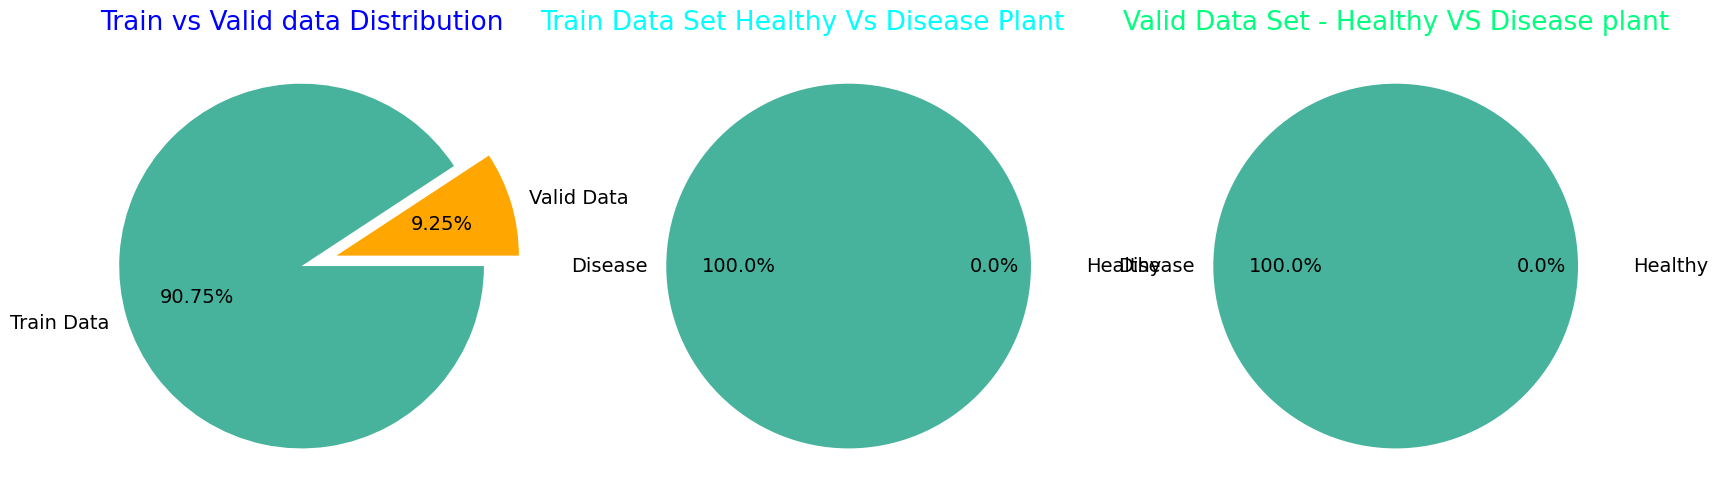

In [11]:
def image_information(data_set_info):
    plt.rcParams["font.size"]=14
    plt.pie([data_set_info.nb[data_set_info.Category=="healthy"].sum(),data_set_info.nb[data_set_info.Category!="health"].sum()],labels=["Healthy","Disease"],autopct=lambda x:str(round(x,1))+"%",colors=["#007CC3","#47B39C"],shadow=False,explode=(0.20,0))


plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Train vs Valid data Distribution",fontsize=19,color="Blue")
plt.rcParams["font.size"]=14

# image_information(valid_data_count)
plt.pie([valid_data_count.nb.sum(),train_data_count.nb.sum()],labels=["Valid Data","Train Data"],autopct=lambda x: str(round(x,2))+"%",colors=["#FFA600","#47B39C"],shadow=False,explode=(0.20,0))
plt.subplot(1,3,2)
plt.title("Train Data Set Healthy Vs Disease Plant "        "          "  ,fontsize=19,color="aqua")
image_information(train_data_count)
plt.subplot(1,3,3)
plt.title('Valid Data Set - Healthy VS Disease plant', fontsize=19,color="springgreen")
image_information(valid_data_count)

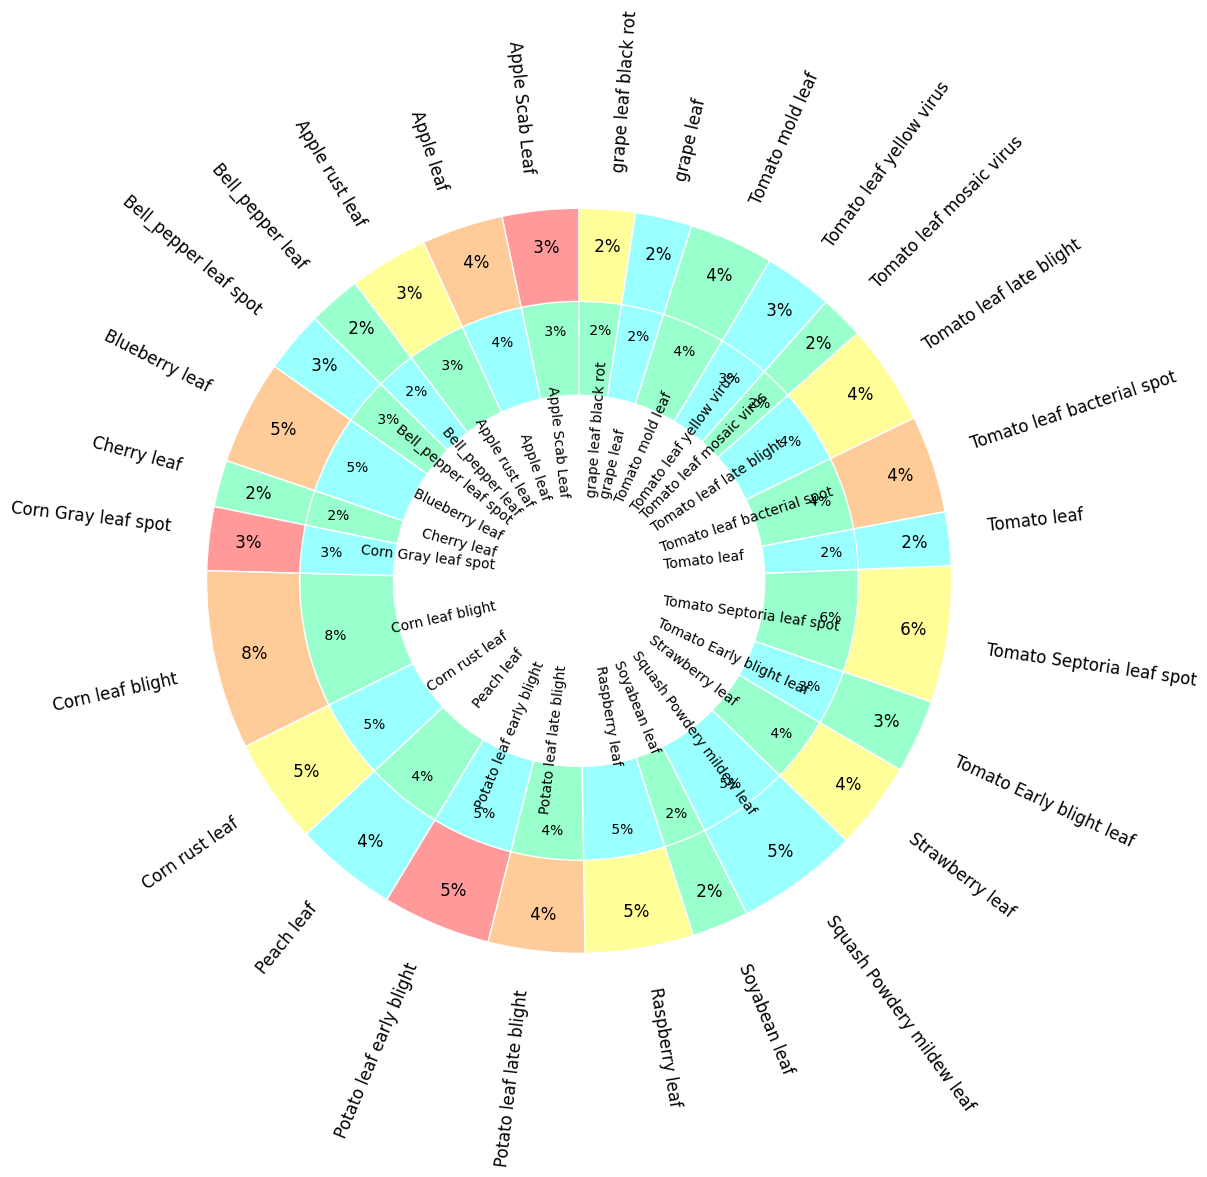

In [12]:
def  class_data_distribution(class_data_count,class_data_info):
    list_plant_mod= ['Cherry' if x == 'Cherry_(including_sour)' else x for x in list(class_data_count.Plant.unique())]


    pi_chart_color_0 = ['#99ffcc', '#99ffff', '#99ffcc', '#99ffff','#99ffcc', '#99ffff','#99ffcc', '#99ffff','#99ffcc', '#99ffff','#99ffcc', '#99ffff','#99ffcc', '#99ffff',]
    pi_chart_color_1 = ['#ff999a','#ffcb99', '#fffe99','#99ffcc',
                                                                                                                 '#99ffff',
                                                                                                                 '#ffcb99', '#99ffcc',
                                                                                                                 '#ff999a','#ffcb99','#fffe99','#99ffff',
                                                                                                                 '#ff999a','#ffcb99','#fffe99','#99ffcc',
                                                                                                                 '#99ffff',
                                                                                                                 '#fffe99','#99ffcc',
                                                                                                                 '#fffe99','#99ffff',
                                                                                                                 '#ffcb99','#fffe99','#99ffcc',
                                                                                                                 '#99ffff',
                                                                                                                 '#99ffcc',
                                                                                                                 '#99ffff',
                                                                                                                 '#fffe99','#99ffcc',
                                                                                                                 '#ff999a','#ff9990','#ffb299','#ffc5b3','#ffece6','#ffedb3','#fff3cd','#d1ffcd','#cdffdf','#99ffff']


    plt.pie(class_data_count.nb, labels=class_data_count.Category,  startangle=90,frame=True,radius=1,rotatelabels=True,colors=pi_chart_color_1,wedgeprops=dict(width=0.9, edgecolor='w'),autopct='%2.f%%',pctdistance=0.90, textprops={'fontsize': 12})
    plt.pie(class_data_info.groupby(['Plant']).size(),labels=list_plant_mod,radius=0.75,startangle=90,labeldistance=0.3,rotatelabels=True,colors=pi_chart_color_0,wedgeprops=dict(width=0.9, edgecolor='w'),autopct='%2.f%%',pctdistance=0.90, textprops={'fontsize': 10})
    centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.axis('equal')
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12,12))
class_data_distribution(train_data_count,train_data_info)

In [13]:
data_dir = "/content/PlantDoc-Dataset"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/test"

In [14]:
diseases = os.listdir(train_dir)
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Squash Powdery mildew leaf,123
Bell_pepper leaf,53
Tomato leaf,54
Corn leaf blight,180
Tomato leaf mosaic virus,44
Tomato leaf bacterial spot,98
Apple Scab Leaf,77
Apple rust leaf,79
Strawberry leaf,88
Tomato mold leaf,85


Text(0.5, 1.0, 'Images per each class of plant disease')

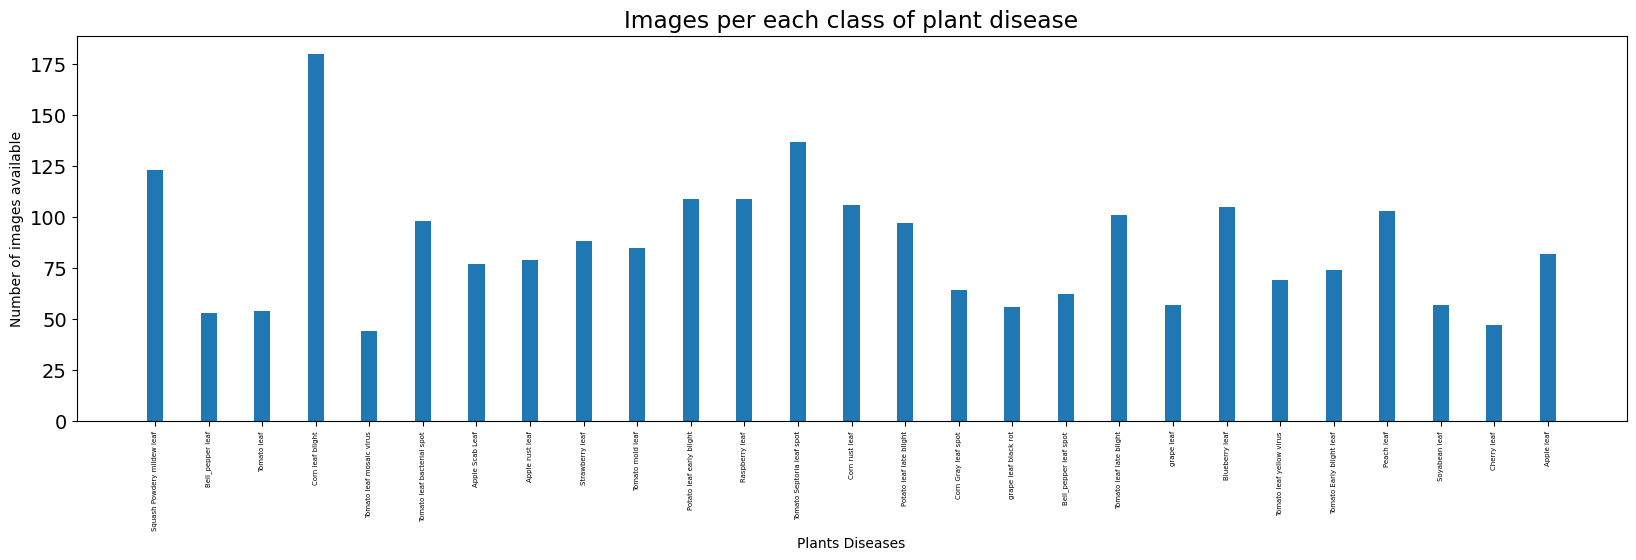

In [15]:
index = [n for n in range(27)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants Diseases', fontsize=10)
plt.ylabel('Number of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [16]:
train_datagen= ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)
val_datagen=ImageDataGenerator()

In [17]:
train= train_datagen.flow_from_directory(train_dir,batch_size=128,target_size=(200,200),color_mode='rgb',class_mode='categorical',seed=42)
valid=val_datagen.flow_from_directory(valid_dir,batch_size=128,target_size=(200,200),color_mode='rgb',class_mode='categorical')

Found 2316 images belonging to 27 classes.
Found 236 images belonging to 27 classes.


In [18]:
classes=list(train.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train:
    for i in range(0,20):
        plt.subplot(5,5,i+1)
        plt.imshow(X_batch[i].astype(np.uint8))
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    plt.show()
    break

Output hidden; open in https://colab.research.google.com to view.

In [19]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(200,200,3),classes=27)
base_model_tf.trainable=False

pt=Input(shape=(200,200,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func)
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(256,activation='relu')(model_resnet)
model_resnet=Dropout(0.5)(model_resnet)  # Add dropout here
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dropout(0.5)(model_resnet)  # Add dropout here
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dropout(0.5)(model_resnet)  # Add dropout here
model_resnet=Dense(27,activation='softmax')(model_resnet)

Model_2=Model(inputs=pt,outputs=model_resnet)
Model_2.summary()
Model_2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history=Model_2.fit(train,validation_data=valid,epochs=100,verbose=1,callbacks=[callback])

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 200, 200, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 200, 200, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 200, 200, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                              

In [20]:
history

In [21]:
Model_2.save("/content/drive/MyDrive/Model/Model_2.h5")

In [22]:
# !tar -zcvf disease_prediction.tgz Model_2.h5

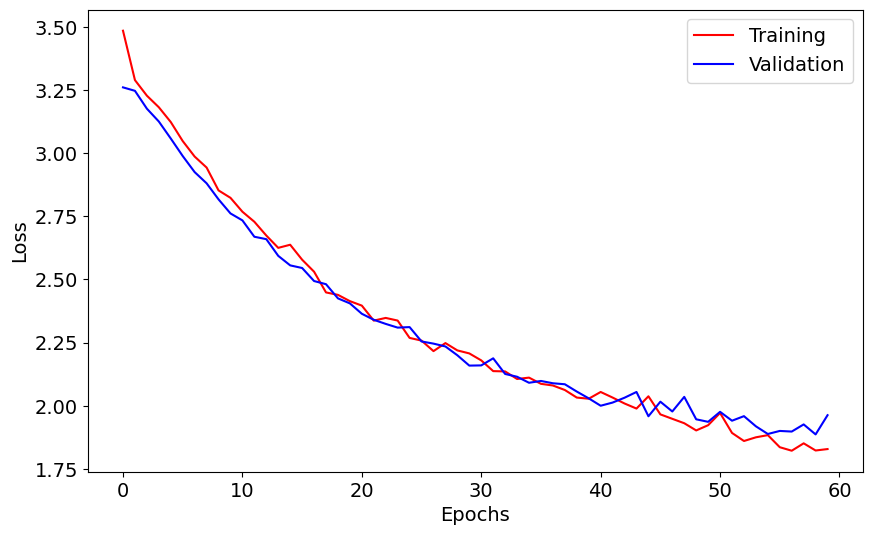

In [23]:
import matplotlib.pyplot as plt
loss =history.history['loss']
val_loss =history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

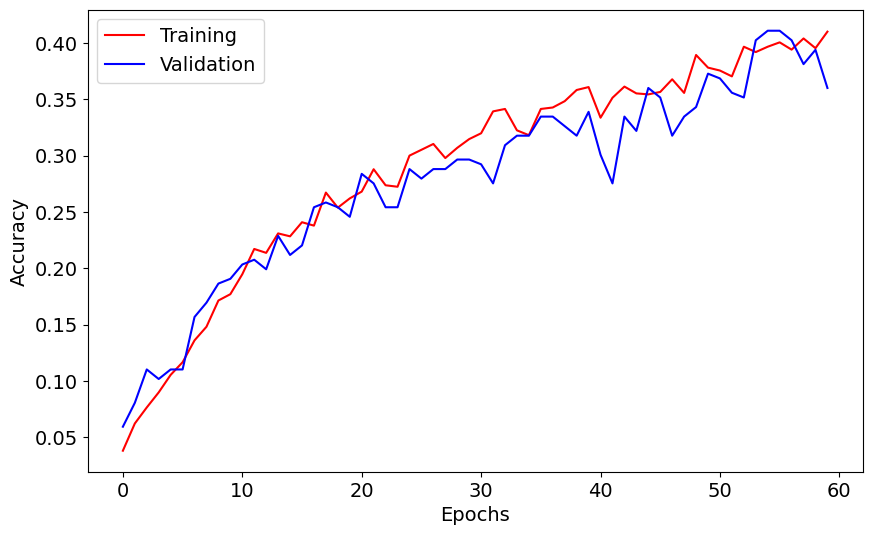

In [24]:
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [25]:
batch_size = 128
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(200, 200),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

Found 2316 images belonging to 27 classes.


In [26]:
class_dict = training_set.class_indices
print(class_dict)

{'Apple Scab Leaf': 0, 'Apple leaf': 1, 'Apple rust leaf': 2, 'Bell_pepper leaf': 3, 'Bell_pepper leaf spot': 4, 'Blueberry leaf': 5, 'Cherry leaf': 6, 'Corn Gray leaf spot': 7, 'Corn leaf blight': 8, 'Corn rust leaf': 9, 'Peach leaf': 10, 'Potato leaf early blight': 11, 'Potato leaf late blight': 12, 'Raspberry leaf': 13, 'Soyabean leaf': 14, 'Squash Powdery mildew leaf': 15, 'Strawberry leaf': 16, 'Tomato Early blight leaf': 17, 'Tomato Septoria leaf spot': 18, 'Tomato leaf': 19, 'Tomato leaf bacterial spot': 20, 'Tomato leaf late blight': 21, 'Tomato leaf mosaic virus': 22, 'Tomato leaf yellow virus': 23, 'Tomato mold leaf': 24, 'grape leaf': 25, 'grape leaf black rot': 26}


In [27]:
li = list(class_dict.keys())
print(li)

['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']


In [30]:
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
model = load_model("/content/drive/MyDrive/Model/Model_2.h5")

import numpy as np
from tensorflow.keras.preprocessing import image

# Load your image
img_path = '/content/PlantDoc-Dataset/test/Corn rust leaf/Corn rust leaf (1).jpg'  # Replace with the actual path to your image
img = image.load_img(img_path, target_size=(200, 200))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
preprocessed_img = img_array  # No need for additional preprocessing since it's already preprocessed in training

li = ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']

predictions = model.predict(preprocessed_img)
predicted_label_index = np.argmax(predictions)
predicted_label = li[predicted_label_index]
print(predicted_label)

1/1 [==============================] - 1s 887ms/step
Corn rust leaf
